# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

2023-07-14 12:49:11.915496: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 12:49:12.126016: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 12:49:12.128598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 12:49:13.144025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from matplotlib import rcParams

from sklearn.ensemble import  RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Some preprocessing

In [3]:
data = pd.read_csv("./collected_data/prepared_data/prestep_data.csv")
data.head()

,vertices,redexes,redex_depths,redex_indexes,heights,widths,steps_time,strategy_name
0,53,3,4,12,15,21,131224,LI
1,50,2,5,27,15,20,187277,LI
2,27,1,1,1,8,10,32085,LI
3,54,6,7,10,13,17,179030,LI
4,51,6,11,16,14,16,179197,LI


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3931 entries, 0 to 3930
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   vertices       3931 non-null   int64 
 1   redexes        3931 non-null   int64 
 2   redex_depths   3931 non-null   int64 
 3   redex_indexes  3931 non-null   int64 
 4   heights        3931 non-null   int64 
 5   widths         3931 non-null   int64 
 6   steps_time     3931 non-null   int64 
 7   strategy_name  3931 non-null   object
dtypes: int64(7), object(1)
memory usage: 245.8+ KB


In [5]:
pca = PCA(2, random_state=42)
data_pca = pca.fit_transform(data[["vertices", "redexes", "redex_depths", "heights", "widths"]])

/tmp/ipykernel_5686/2351182786.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")


<Axes: >

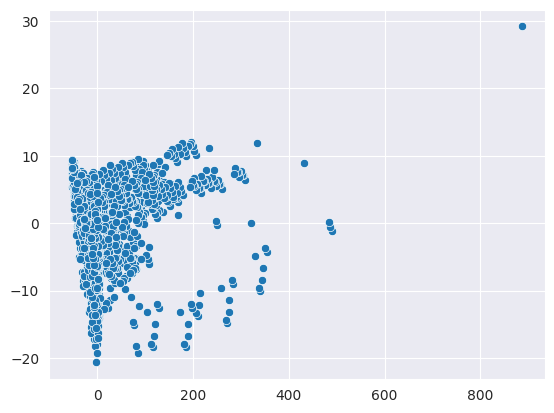

In [6]:
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], palette="deep")

<Axes: >

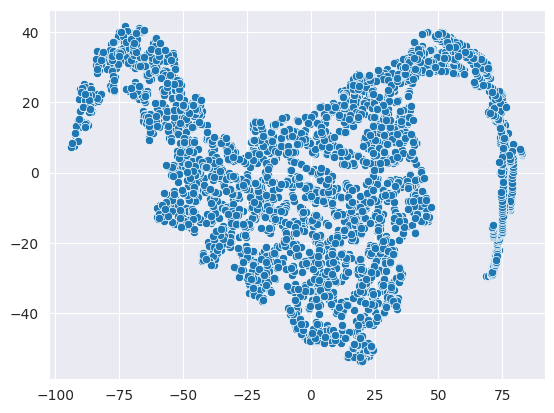

In [7]:
tsne = TSNE(random_state=3)
tsne_feature = tsne.fit_transform(data[["vertices", "redexes", "redex_depths", "heights", "widths"]])
sns.scatterplot(x=tsne_feature[:, 0], y=tsne_feature[:, 1])

## Check skewed features

In [8]:
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

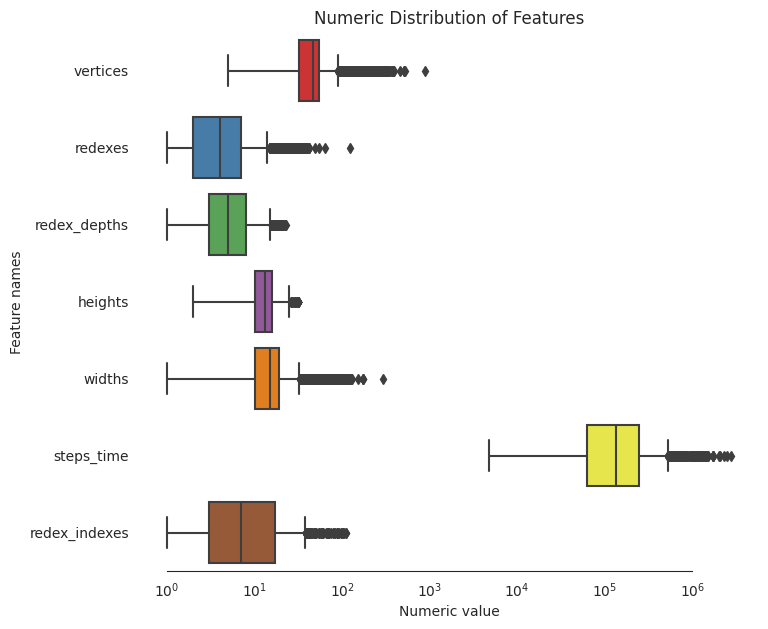

In [9]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time", "redex_indexes"]], orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric value")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [10]:
# Find skewed numerical features
skew_features = data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time", "redex_indexes"]].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print(f"There are {high_skew.shape[0]} numerical features with skew > 0.5: ")
skewness = pd.DataFrame({"skew": skew_features})
skewness.head(10)

There are 6 numerical features with skew > 0.5: 


,skew
vertices,4.235690
widths,4.148381
redexes,3.953192
steps_time,3.692667
redex_indexes,2.305134
redex_depths,1.034103
heights,0.428418


array([[<Axes: title={'center': 'vertices'}>,
        <Axes: title={'center': 'redexes'}>,
        <Axes: title={'center': 'redex_depths'}>],
       [<Axes: title={'center': 'redex_indexes'}>,
        <Axes: title={'center': 'heights'}>,
        <Axes: title={'center': 'widths'}>],
       [<Axes: title={'center': 'steps_time'}>, <Axes: >, <Axes: >]],
      dtype=object)

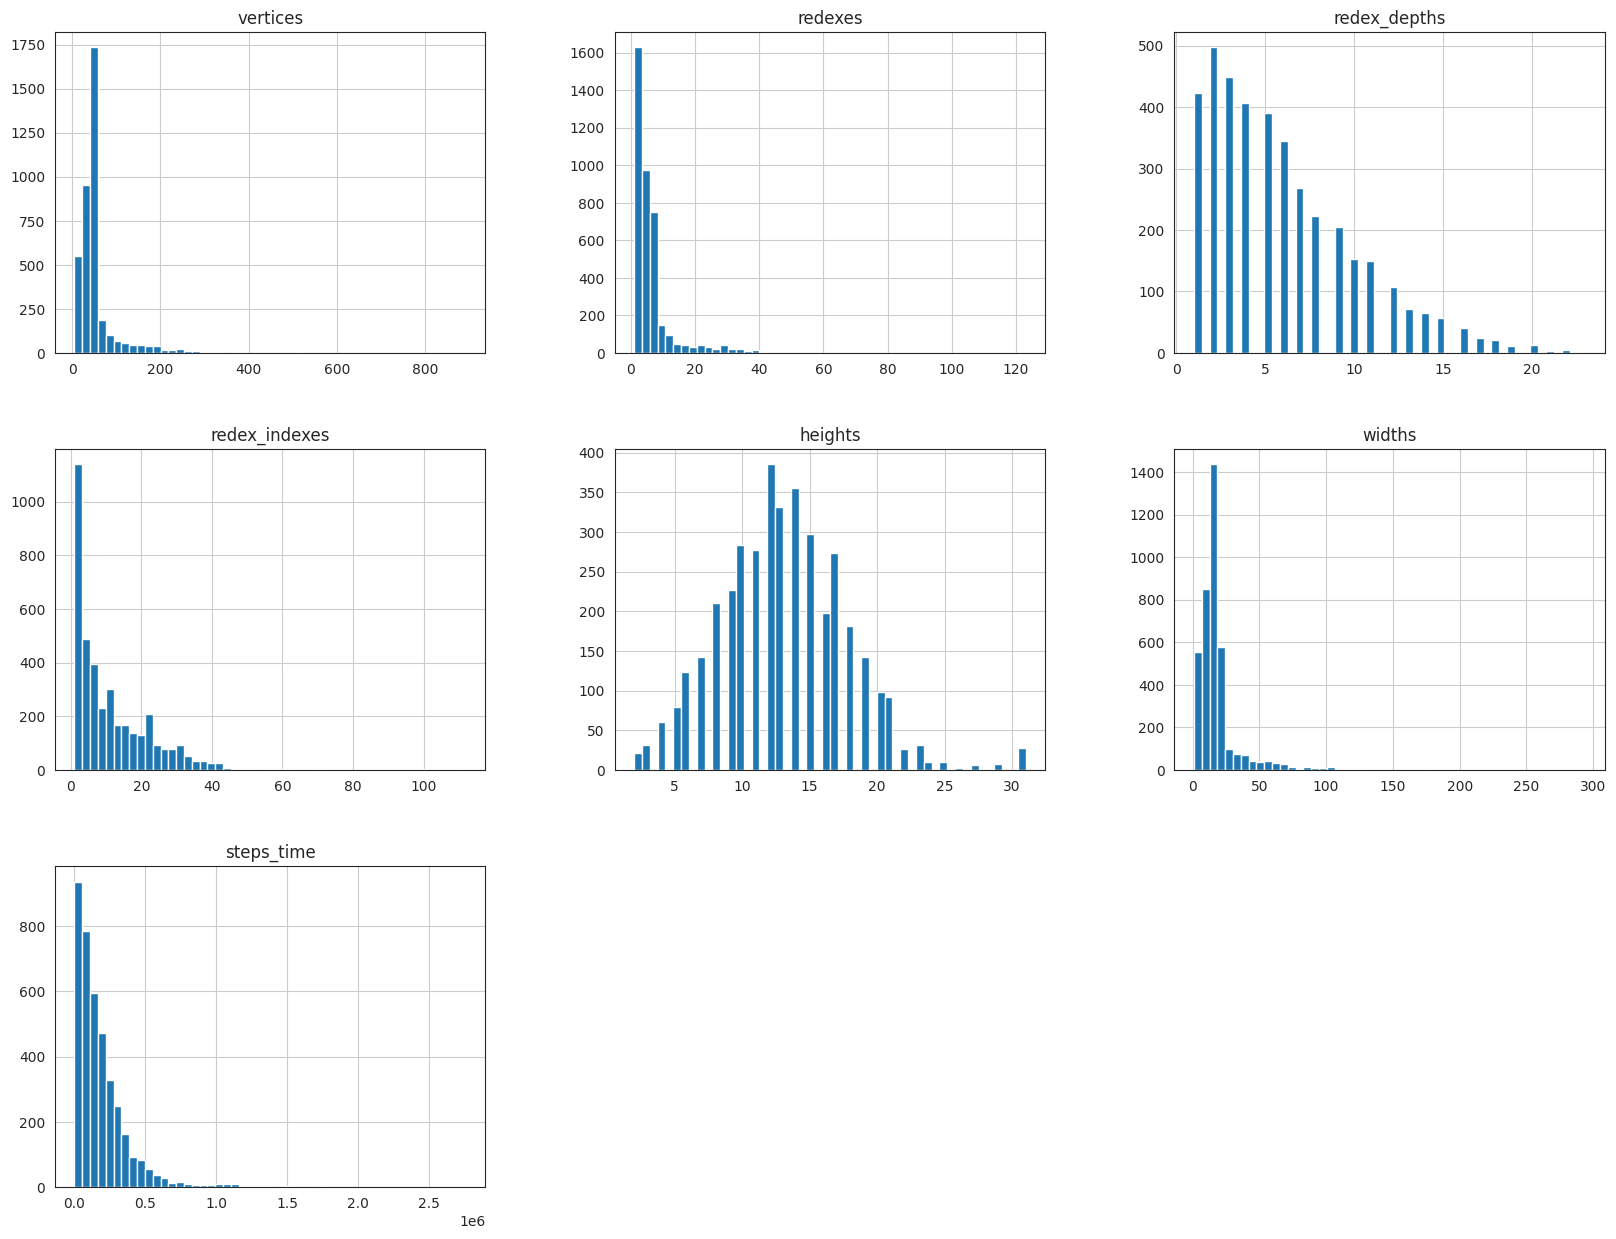

In [12]:
rcParams['figure.figsize'] = 20, 15
data.hist(bins=50)

In [19]:
data_for_training = data[["vertices", "redexes", "redex_depths", "heights", "widths", "steps_time"]]


def split_dataset(dataset, test_ratio=0.3):
    test_indices_filter = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices_filter], dataset[test_indices_filter]


train_ds, test_ds = split_dataset(data_for_training)
print(f"Examples for training {len(train_ds)}")
print(f"Examples for testing {len(test_ds)}")

Examples for training 2774
Examples for testing 1157


In [23]:
x_train, y_train = train_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], train_ds[["steps_time"]]
x_test, y_test = test_ds[["vertices", "redexes", "redex_depths", "heights", "widths"]], test_ds[["steps_time"]]

In [ ]:
x_train,

# Train with Random Forest

In [25]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_train, y_train)

y_train_pred = rf_regressor.predict(x_train)
y_test_pred = rf_regressor.predict(x_test)

rmse_train = mean_squared_error(y_train, y_train_pred)
rmse_test = mean_squared_error(y_test, y_test_pred)

print("TRAIN Root Mean Squared Error(RMSE):", rmse_train)
print("TEST Root Mean Squared Error(RMSE):", rmse_test)

/home/vol/Documents/python_projects/pure-calculus/venv/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


TRAIN Root Mean Squared Error(RMSE): 23278.073315487203
TEST Root Mean Squared Error(RMSE): 55934.4149998183


In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(data_for_training, y_train)